In [1]:
import os
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

from sklearn.metrics import roc_auc_score
from uuid import uuid4

In [78]:

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

In [91]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\results'
logs_path = '../storage/results/dataset-can-cifar10'
logs_path = '../storage/results/dataset-rec-fmnist'

In [92]:
exp_dict = {}
environments = []
for log_file in glob(logs_path + '/**/*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop.split('-', 1) for prop in log_file.replace(logs_path, '').split('\\')[1:-1]]
        props = {prop[0]: prop[1] for prop in props_list}
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exps = {exp['id']: exp for exp in exps}
        exp_dict = {**exp_dict, **exps}

../storage/results/dataset-rec-fmnist/logs.pyd


In [93]:
def print_exp_info(exp: dict):
    print({k: exp[k] for k in exp if k not in ['auc_final', 'auc_average', 'auc_per_task', 'conf_matrix_per_task']})

# print_exp_info(environments[0]['exps'][0])

In [94]:
def get_df_form_dict(d: dict):
    return pd.DataFrame.from_dict(d, orient='index')

In [95]:
def show_aucs_per_task(task_aucs: pd.DataFrame, annotations: pd.DataFrame=None):
    fig, ax = plt.subplots(figsize=(10, len(task_aucs)+1))
    sns.heatmap(task_aucs,
                annot=annotations if annotations is not None else True,
                fmt='' if annotations is not None else '.2g',
                ax=ax, cmap='Reds', cbar=False)
    plt.ylabel('Task')
    plt.xlabel('Class')
    plt.title('Auc per task and class')
    plt.show()

# show_aucs_per_task(pd.DataFrame.from_dict(environments[0]['exps'][0]['auc_per_task'], orient='index'))

In [96]:
def show_conf_matrix(cmatrix: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(10, len(cmatrix)+1))
    sns.heatmap(data=cmatrix, ax=ax,annot=True, cbar=False, cmap='Reds')
    plt.ylabel('Task')
    plt.xlabel('Class')
    plt.title('Reconstruction error per task and class')
    plt.show()

# show_conf_matrix(pd.DataFrame.from_dict(environments[0]['exps'][0]['conf_matrix_per_task'], orient='index'))

In [97]:
def disclosure_experiment(exp: dict, info=True, aucs=True, cmatrix=True):
    ## print metrics of experiments
    if info:
        print_exp_info(exp)
    if aucs:
        print(f'final {exp["auc_final"]} average {exp["auc_average"]}')
        show_aucs_per_task(get_df_form_dict(exp['auc_per_task']))

    if cmatrix:
        show_conf_matrix(get_df_form_dict(exp['conf_matrix_per_task']))

# disclosure_experiment(exp_dict['a8b7df79-7031-4f95-ba9c-aaae316ced5e'])

In [102]:
useless_cols = ['seed', 'logs', 'auc_per_task', 'conf_matrix_per_task']
# cols without duplicates
model_cols = {
    'common_pre': ['n_epochs', 'batch_size', 'optim', 'lr', 'model'],
    'ae': ['latent_space'],
    'dae': ['noise_mean', 'noise_std'],
    'sae': ['sparse_weight', 'norm_order'],
    'vae': ['kl_weight', 'beta_kl', 'forward_sample'],
    'rec-vae': ['kl_weight', 'forward_sample'],
    'common_post': ['joint', 'splits']
}
result_cols = ['rec_mean']

group_cols = [col for cols in model_cols for col in model_cols[cols]]+['timestamp']
order_cols = group_cols + ['id'] + result_cols

methods_list = []
def method_id(df: pd.DataFrame):
    idx = len(methods_list)
    methods_list.append({'exps': list(df)})
    return idx

for env in environments:
    env_cols = [prop for prop in env['env']]

    results = pd.DataFrame.from_records(env['exps'])
    tot_cols = results.columns.tolist()
    exclude_cols = list(set(col for col in useless_cols + env_cols if col in tot_cols))
    orderby_cols = list(set(col for col in order_cols if col in tot_cols))
    groupby_cols = list(set(col for col in group_cols if col in tot_cols))
    unknown_cols = list(set(col for col in tot_cols if col not in exclude_cols + orderby_cols))
    env['unknown'] = unknown_cols
    results = results[orderby_cols]
    results['runs'] = 1
    results = results.groupby(groupby_cols, dropna=False).agg(
        {'runs': 'count', 'id': method_id,
         # **{res: ['mean', 'std'] for res in result_cols}
         }
    )
    for index, res in results.iterrows():
        id_met = int(res['id'])
        methods_list[id_met]['props'] = {name: index[i] for i, name in enumerate(results.index.names)}
        methods_list[id_met]['env'] = env['env']
        # methods_list[id_met]['results'] = {res_col: {'mean': res[(res_col, 'mean')], 'std': res[(res_col, 'std')]} for res_col in result_cols}

    env['results'] = results

sort = False
sort_col = ('auc_final', 'mean')
for env in environments:
    print('ENV INFO - ' + str(env['env']))
    if len(env['unknown']):
        print('-- unknown props: ' + str(env['unknown']))
    display(env['results'].sort_values(sort_col, ascending=False) if sort else env['results'])
    print('-'*100 + '\n')

ENV INFO - {}
-- unknown props: ['classes_per_task', 'poison_perc', 'poison', 'min_max_rotation', 'add_rotation', 'approach', 'wandb', 'dataset']


runs  id
optim latent_space lr  timestamp                  kl_weight n_epochs forward_sample model   batch_size          
sgd   32           0.1 2022-02-25 17:58:29.941102 1.0       1        True           rec-vae 64             1   0
                       2022-02-25 18:21:08.805836 1.0       20       True           rec-vae 64             1   1
                       2022-02-25 19:23:26.058050 1.0       20       True           rec-vae 64             1   2

----------------------------------------------------------------------------------------------------



In [103]:
def agg_annots(df: pd.DataFrame):
    m, s = list(df)
    if np.isnan(m):
        return str(m)
    return f'{m:.2f}±{s:.2f}'

def disclosure_method(idx: int, info=False, aucs=False, cmatrix=False):
    method = methods_list[idx]
    print(f'METHOD {idx}')
    print('ENV - ' + str(method['env']))
    print('PROPS - ' + str(method['props']))
    # print('RESULTS - ' + str(method['results']))
    print(f'EXPERIMENTS ({len(method["exps"])}):')
    exps = [exp_dict[eid] for eid in method['exps']]
    # for exp in exps:
    #     print(f'-- {exp["id"]}: \tauc-final {exp["auc_final"]:.4f} \tauc-average {exp["auc_average"]:.4f} \t {"logs" if exp["logs"] == True else ""}')

    if info:
        print('INFO')
        for exp in exps:
            print_exp_info(exp)
    if aucs:
        exp_aucs = [get_df_form_dict(exp['auc_per_task']) for exp in exps]
        df = pd.concat(exp_aucs)
        means = df.groupby(level=0).mean()
        stds = df.groupby(level=0).std()
        annots = pd.concat([means, stds]).groupby(level=0).agg(agg_annots)
        # display(annots)
        show_aucs_per_task(means, annotations=annots)

    if cmatrix:
        exp_aucs = [get_df_form_dict(exp['conf_matrix_per_task']) for exp in exps]
        df = pd.concat(exp_aucs)
        means = df.groupby(level=0).mean()
        stds = df.groupby(level=0).std()
        annots = pd.concat([means, stds]).groupby(level=0).agg(agg_annots)
        # display(annots)
        show_conf_matrix(means)

METHOD 2
ENV - {}
PROPS - {'optim': 'sgd', 'latent_space': 32, 'lr': 0.1, 'timestamp': '2022-02-25 19:23:26.058050', 'kl_weight': 1.0, 'n_epochs': 20, 'forward_sample': True, 'model': 'rec-vae', 'batch_size': 64}
EXPERIMENTS (1):


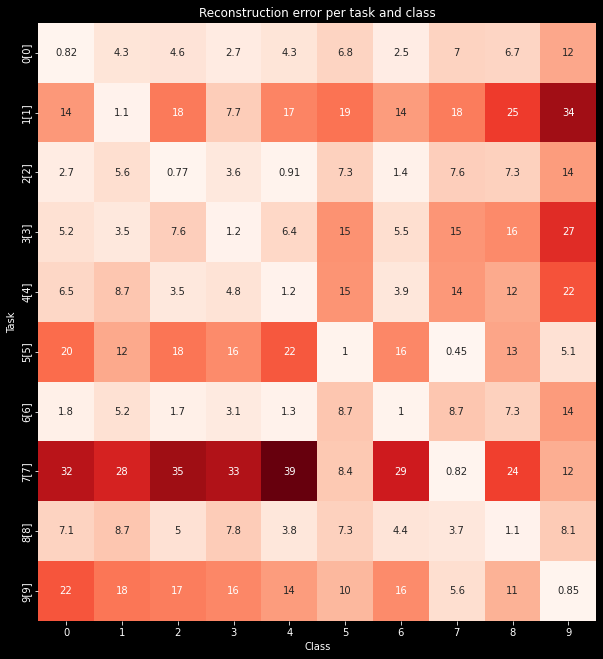

METHOD 1
ENV - {}
PROPS - {'optim': 'sgd', 'latent_space': 32, 'lr': 0.1, 'timestamp': '2022-02-25 18:21:08.805836', 'kl_weight': 1.0, 'n_epochs': 20, 'forward_sample': True, 'model': 'rec-vae', 'batch_size': 64}
EXPERIMENTS (1):


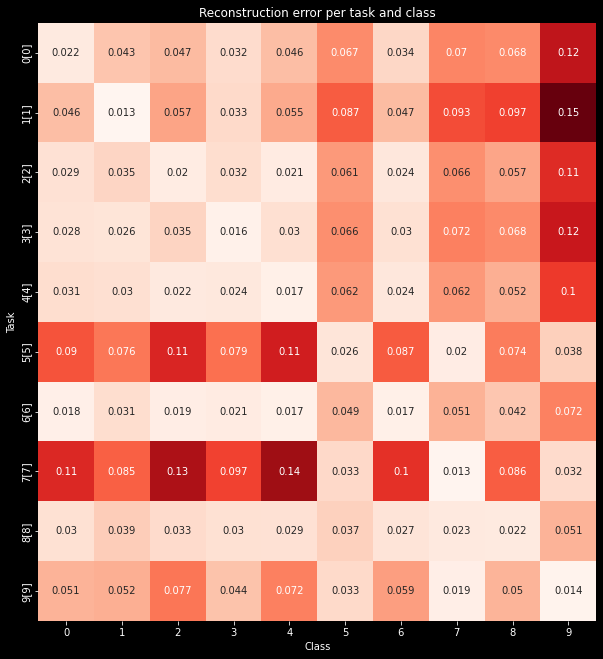

In [107]:
disclosure_method(2, info=False, aucs=False, cmatrix=True)
disclosure_method(1, info=False, aucs=False, cmatrix=True)
# disclosure_method(2, info=False, aucs=True, cmatrix=True)
# disclosure_method(30, info=False, aucs=True, cmatrix=True)